In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

In [2]:
%%time
train_transaction = pd.read_csv('newtrain_transaction_200000.csv', index_col='TransactionID')
test_transaction = pd.read_csv('newtest_transaction_withoutlabel.csv', index_col='TransactionID')

train_identity = pd.read_csv('newtrain_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('newtest_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('newsample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

y_train = train['isFraud'].copy()
del train_transaction, train_identity, test_transaction, test_identity

# Drop target
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train, test

(80397, 433)
(10000, 432)
Wall time: 4.35 s


In [4]:
X_test_filter = X_test.copy()
X_train_filter = X_train.copy()


### drop all the NaN columns
for column in X_test_filter.columns:
    if pd.isnull(X_test_filter[column].unique()[0]):
        X_train_filter.drop([column], axis = 1, inplace=True)
        X_test_filter.drop([column], axis = 1, inplace=True)

In [5]:
# Label Encoding
def label_encoding(X_train, X_test):
    for f in X_train.columns:
        if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(X_train[f].values) + list(X_test[f].values))
            X_train[f] = lbl.transform(list(X_train[f].values))
            X_test[f] = lbl.transform(list(X_test[f].values))
    return X_train, X_test


In [6]:
X_train_filter_, X_test_filter_ = label_encoding(X_train_filter, X_test_filter)

In [7]:
def fill_na_df(X_train, X_test):
    for col_name in X_train.columns: 
        X_train[col_name].fillna(X_train[col_name].mode()[0], inplace=True)
        X_test[col_name].fillna(X_test[col_name].mode()[0], inplace=True)

In [8]:
X_train_filter_fill = X_train_filter_.copy()
X_test_filter_fill = X_test_filter_.copy()
fill_na_df(X_train_filter_fill, X_test_filter_fill)

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [10]:
%%time
X_train_filter_fill = reduce_mem_usage(pd.DataFrame(X_train_filter_fill))
X_test_filter_fill = reduce_mem_usage(pd.DataFrame(X_test_filter_fill))

Memory usage of dataframe is 138.62 MB
Memory usage after optimization is: 37.19 MB
Decreased by 73.2%
Memory usage of dataframe is 17.24 MB
Memory usage after optimization is: 4.58 MB
Decreased by 73.5%
Wall time: 10.4 s


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

sc = StandardScaler()
X_train_filter_fill = sc.fit_transform(X_train_filter_fill)
X_test_filter_fill = sc.fit_transform(X_test_filter_fill)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_train_filter_fill, y_train, test_size=0.1, random_state=1)

In [12]:
from keras.layers import *
from keras import models
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [13]:
import keras.backend as K

def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
#resnet18-conv_block
def conv_block(input_tensor, filters, kernel, stride = 2):
    x = Conv1D(filters, kernel_size= kernel, strides = stride, padding = 'same')(input_tensor)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(filters, kernel_size= kernel, strides = 1, padding = 'same')(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, kernel_size= 1, strides = stride, padding = 'same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

In [15]:
#resnet18-Identity_block
def identity_block(input_tensor, filters, kernel):
    x = Conv1D(filters, kernel_size= kernel, strides = 1, padding = 'same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(filters, kernel_size= kernel, strides = 1, padding = 'same')(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    
    return x

In [16]:
# using channel attention module
def attention(input_tensor):
    input_channels = int(input_tensor.shape[-1])
    x = GlobalAveragePooling1D()(input_tensor)
    x = Dense(int(input_channels/4))(x)
    x = Activation('relu')(x)
    x = Dense(input_channels)(x)
    x = Activation('sigmoid')(x)
    x = Reshape((1,  input_channels))(x)
    x = Multiply()([input_tensor, x])
    
    return x

In [17]:
def resnet_18_1D(length):
    inputs = Input((length, 1))
    x = Conv1D(64, 7, strides = 2, padding = 'same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D()(x)
    
    x = conv_block(x, 64, 3, stride = 1)
    x = identity_block(x, 64, 3)
    
    x = conv_block(x, 128, 3)
    x = identity_block(x, 128, 3)
    
    x = conv_block(x, 256, 3)
    x = identity_block(x, 256, 3)
    
    x = conv_block(x, 256, 3)
    x = identity_block(x, 256, 3)
    
    x = attention(x)
    x = GlobalAvgPool1D()(x)
    #x = Dropout(0.2)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs = inputs, outputs = x)
    
    return model

In [25]:
log_dir = "logs/"

In [78]:
fraud = models.load_model(log_dir+'last1.h5', custom_objects={'f1': f1})

KeyboardInterrupt: 

In [18]:
fraud = resnet_18_1D(X_train2.shape[-1])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
fraud.compile(optimizer = Adam(lr=1e-2), loss = "binary_crossentropy", metrics=[f1])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
fraud.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 225, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 113, 64)      512         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 113, 64)      256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 113, 64)      0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [21]:
Y_train2.values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [22]:
Y_train2_ = preprocessing.OneHotEncoder(categories='auto').fit_transform(Y_train2.values.reshape(-1,1)).toarray()

In [23]:
Y_test2_ = preprocessing.OneHotEncoder(categories='auto').fit_transform(Y_test2.values.reshape(-1,1)).toarray()

In [24]:
X_train2_ = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], 1)
X_test2_ = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], 1)

In [26]:
#save the model(every 5 epoches)
checkpoint_period = ModelCheckpoint(
                                    log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                                    monitor='val_loss', 
                                    save_weights_only=False, 
                                    save_best_only=True, 
                                    period=5
                                )

In [27]:
#reduce the lr, if the val_loss does not reduce in 3 epoches, then reduce the lr, factor is 0.5
reduce_lr = ReduceLROnPlateau(
                            monitor='val_loss', 
                            factor=0.5, 
                            patience=3, 
                            verbose=1
                        )

In [28]:
#early stopp
early_stopping = EarlyStopping(
                            monitor='val_loss', 
                            min_delta=0, 
                            patience=10, 
                            verbose=1
                        )


In [ ]:
history = fraud.fit(X_train2_, Y_train2, batch_size=32, epochs=40, validation_data=(X_test2_, Y_test2)
                   , callbacks=[checkpoint_period, reduce_lr, early_stopping])

In [80]:
fraud.save(log_dir+'last1.h5')

In [59]:
score=fraud.evaluate(X_test2_, Y_test2,batch_size=80)

8040/8040 [==============================] - 2s 200us/step


In [60]:
import matplotlib.pyplot as plt

In [62]:
print(history.history.keys())

dict_keys(['val_loss', 'val_f1', 'loss', 'f1', 'lr'])


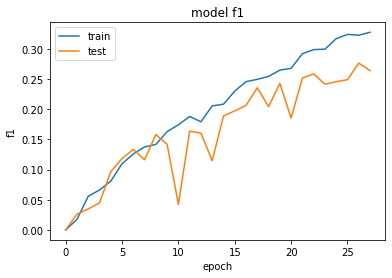

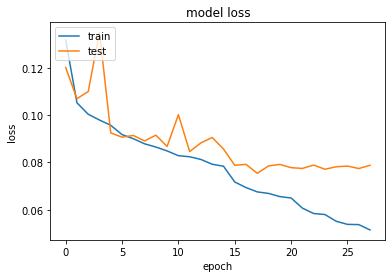

In [66]:
# summarize history for accuracy
plt.plot(history.history['f1'])

plt.plot(history.history['val_f1'])

plt.title('model f1')

plt.ylabel('f1')

plt.xlabel('epoch')

plt.legend(['train','test'], loc='upper left')

plt.show()

# summarize history for loss

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train','test'], loc='upper left')
plt.show()

In [117]:
output1 = fraud.predict(X_test2_)
output0 = fraud.predict(X_train2_)

In [118]:
roc_auc_score(Y_test2, output1)

0.8972590881255915

In [119]:
roc_auc_score(Y_train2, output0)

0.9546375002326792

In [109]:
output = fraud.predict(X_test_filter_fill.reshape(X_test_filter_fill.shape[0], X_test_filter_fill.shape[1], 1))

In [110]:
output

array([[5.0797760e-03],
       [1.5461445e-04],
       [1.9681454e-04],
       ...,
       [1.3430417e-03],
       [4.7385693e-06],
       [6.9473982e-03]], dtype=float32)

In [113]:
newsample_submission = pd.read_csv('newsample_submission.csv', index_col = 'TransactionID')

In [116]:
newsample_submission['isFraud'] = output
newsample_submission.to_csv('newsample_submission1.csv')